In [1]:
from tool import *
from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.drawing.image import Image
from openpyxl.styles import PatternFill, Alignment, Font

# general options
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [2]:
def make_otd_raw_data(otd, use_boh='Y'):
    col_list2 = []
    for col in otd.columns:
        if col[0] in thismonth_wklist[:thismonth_wklist.index(thisweek)] + weeklist[weeklist.index(thisweek):]:
            if col[1] in ['SP', 'Input']:
                col_list2.append((col[0], col[1]))

    otd = otd[col_list2].fillna(0) # 필요한 column 리스트로만 구성함
    otd = otd[otd.sum(axis=1) != 0] # 각 행의 값의 합이 0 인것은 제외함

    wk_loop = thismonth_wklist[:thismonth_wklist.index(thisweek)] + weeklist[weeklist.index(thisweek):] # 향후 for 문에 사용할 대상 주차들을 리스트로 만들어둠

    for week in wk_loop: # for문 돌면서 해당 week에 'input' 컬럼이 없을 경우 0 으로 채워서 생성
        if (week, 'Input') not in otd.columns:
            otd[(week, 'Input')] = 0
            
    for i, week in enumerate(wk_loop): # 해당 주차별로 for 문 돌면서 각 주별 BOH(기초재고), 이번주부터 BOH 기반 예상 SP, 예상 OTD 산출하는 로직임
        if i == 0:
            if use_boh == 'Y':
                otd[(week, 'BOH')] = 0
                boh = get_quanta_boh(today)[['Mapping Model.Suffix', 'BOH']]
                for row in boh.iterrows():
                    otd.loc[row[1]['Mapping Model.Suffix'], (week, 'BOH')] = row[1]['BOH']
                otd = otd.fillna(0) # 위에서 BOH 재고 업데이트하면서 물동에 없는 BOH 모델이 추가되면서 나머지 값들이 'NA' 로 들어가는 경우 해당값을 0 으로 만들어 주기 위함
                if i == wk_loop.index(thisweek):
                    for model in otd.index:
                        if otd.loc[model, (week, 'BOH')] >= otd.loc[model, (week, 'SP')]: # 이번주 기초재고가 SP보다 클 경우 
                            otd.loc[model, (week, 'SP(Estimated)')] = otd.loc[model, (week, 'SP')] # 예상SP가 SP가 되고
                        else:
                            otd.loc[model, (week, 'SP(Estimated)')] = otd.loc[model, (week, 'BOH')] # 아니면, 예상SP는 기초재고가 됨
                            
                        if otd.loc[model, (week, 'SP')] > 0: # 예상 OTD를 계산하기 위해 SP값이 0이 아닐 경우만
                            otd.loc[model, (week, 'OTD(Estimated)')] = round(otd.loc[model, (week, 'SP(Estimated)')] / otd.loc[model, (week, 'SP')] * 100, 1) # 예상SP / SP * 100 으로 계산함
                        
                        otd.loc[model, (week, 'Shortage/Excess')] = otd.loc[model, (week, 'BOH')] - otd.loc[model, (week, 'SP')]
            else:
                otd[(week, 'BOH')] = 0 # otd 예상의 첫번째 컬럼의 BOH는 월 첫주차 기초 재고이므로 Quanta로부터 입수 필요하나, 없으면 0 으로 설정함
                if i == wk_loop.index(thisweek):
                    for model in otd.index:
                        if otd.loc[model, (week, 'BOH')] >= otd.loc[model, (week, 'SP')]: # 이번주 기초재고가 SP보다 클 경우 
                                otd.loc[model, (week, 'SP(Estimated)')] = otd.loc[model, (week, 'SP')] # 예상SP가 SP가 되고
                        else:
                            otd.loc[model, (week, 'SP(Estimated)')] = otd.loc[model, (week, 'BOH')] # 아니면, 예상SP는 기초재고가 됨
                        
                        if otd.loc[model, (week, 'SP')] > 0: # 예상 OTD를 계산하기 위해 SP값이 0이 아닐 경우만
                            otd.loc[model, (week, 'OTD(Estimated)')] = round(otd.loc[model, (week, 'SP(Estimated)')] / otd.loc[model, (week, 'SP')] * 100, 1) # 예상SP / SP * 100 으로 계산함
                        
                        otd.loc[model, (week, 'Shortage/Excess')] = otd.loc[model, (week, 'BOH')] - otd.loc[model, (week, 'SP')]
        else:
            if i < wk_loop.index(thisweek): # 주차별로 loop을 돌면서 해당 주차가 이번주 이전의 주차일 때
                for model in otd.index:
                    boh_thisweek = otd.loc[model, (wk_loop[i-1], 'BOH')] + otd.loc[model, (wk_loop[i-1], 'Input')] - otd.loc[model, (wk_loop[i-1], 'SP')] # 산술적으로는 이전주차 BOH + 이전주차 Input - 이전주차 SP 값이 금주 BOH가 됨
                    if boh_thisweek > 0:  # 금주 BOH 계산값이 양수라면, 
                        otd.loc[model, (week, 'BOH')] = boh_thisweek # 해당 주차의 BOH는 이전주차의 BOH + 이전주차 Input - 이전주차 SP 수량으로 설정
                    else: # 금주 BOH값이 0 또는 음수라면, 전주 BOH와 Input 수량을 합한 수량보다 SP 실적이 같거나 많았다는 것이므로 알수 없는 재고가 있어서 선적을 한 것이라고 보고
                        otd.loc[model, (week, 'BOH')] = 0 # 지난 주 모든 재고를 활용하여 선적을 다했다는 것으로 보고 금주 BOH는 0 으로 설정
            else:
                if i == wk_loop.index(thisweek): # 해당 주차가 이번주일 때
                    for model in otd.index:
                        boh_thisweek = otd.loc[model, (wk_loop[i-1], 'BOH')] + otd.loc[model, (wk_loop[i-1], 'Input')] - otd.loc[model, (wk_loop[i-1], 'SP')] # 산술적으로는 이전주차 BOH + 이전주차 Input - 이전주차 SP 값이 금주 BOH가 됨
                        if boh_thisweek > 0:  # 금주 BOH 계산값이 양수라면, 
                            otd.loc[model, (week, 'BOH')] = boh_thisweek # 해당 주차의 BOH는 이전주차의 BOH + 이전주차 Input - 이전주차 SP 수량으로 설정
                        else: # 금주 BOH값이 0 또는 음수라면, 전주 BOH와 Input 수량을 합한 수량보다 SP 실적이 같거나 많았다는 것이므로 알수 없는 재고가 있어서 선적을 한 것이라고 보고
                            otd.loc[model, (week, 'BOH')] = 0 # 지난 주 모든 재고를 활용하여 선적을 다했다는 것으로 보고 금주 BOH는 0 으로 설정
                        
                        if otd.loc[model, (week, 'BOH')] >= otd.loc[model, (week, 'SP')]: # 이번주 기초재고가 SP보다 클 경우 
                            otd.loc[model, (week, 'SP(Estimated)')] = otd.loc[model, (week, 'SP')] # 예상SP가 SP가 되고
                        else:
                            otd.loc[model, (week, 'SP(Estimated)')] = otd.loc[model, (week, 'BOH')] # 아니면, 예상SP는 기초재고가 됨

                        if otd.loc[model, (week, 'SP')] > 0: # 예상 OTD를 계산하기 위해 SP값이 0이 아닐 경우만
                            otd.loc[model, (week, 'OTD(Estimated)')] = round(otd.loc[model, (week, 'SP(Estimated)')] / otd.loc[model, (week, 'SP')] * 100, 1) # 예상SP / SP * 100 으로 계산함
                        
                        otd.loc[model, (week, 'Shortage/Excess')] = otd.loc[model, (week, 'BOH')] - otd.loc[model, (week, 'SP')]
                else: # 해당 주차가 이번주보다 클 경우임
                    for model in otd.index:
                        otd.loc[model, (week, 'BOH')] = otd.loc[model, (wk_loop[i-1], 'BOH')] - otd.loc[model, (wk_loop[i-1], 'SP(Estimated)')] + otd.loc[model, (wk_loop[i-1], 'Input')]
                        if (wk_loop[i-1], 'CO') in otd.columns:
                            otd.loc[model, (week, 'CO')] = otd.loc[model, (wk_loop[i-1], 'SP')] + otd.loc[model, (wk_loop[i-1], 'CO')] - otd.loc[model, (wk_loop[i-1], 'SP(Estimated)')]
                        else:
                            otd.loc[model, (week, 'CO')] = otd.loc[model, (wk_loop[i-1], 'SP')] - otd.loc[model, (wk_loop[i-1], 'SP(Estimated)')]

                        if otd.loc[model, (week, 'BOH')] >= otd.loc[model, (week, 'SP')] + otd.loc[model, (week, 'CO')]:
                            otd.loc[model,(week, 'SP(Estimated)')] = otd.loc[model, (week, 'SP')] + otd.loc[model, (week, 'CO')]
                        else:
                            otd.loc[model,(week, 'SP(Estimated)')] = otd.loc[model, (week, 'BOH')]

                        if otd.loc[model, (week, 'SP')] + otd.loc[model, (week, 'CO')] > 0:
                            otd.loc[model, (week, 'OTD(Estimated)')] = round(otd.loc[model, (week, 'SP(Estimated)')] / (otd.loc[model, (week, 'SP')] + otd.loc[model, (week, 'CO')]) * 100, 1)
                        
                        otd.loc[model, (week, 'Shortage/Excess')] = otd.loc[model, (week, 'BOH')] - otd.loc[model, (week, 'SP')] - otd.loc[model, (week, 'CO')]

    otd = otd.sort_index(axis=1)
    otd.insert(0, 'Series', pd.Series(otd.index, index=otd.index).apply(lambda x:x.split('-')[0]).replace(srt_model))
    otd.insert(1, 'Country', pd.Series(otd.index, index=otd.index).map(temp_dic))

    row_num = otd[otd['Country'].isnull()].shape[0]
    no_country_model = otd.loc[otd['Country'].isnull()].index
    if row_num > 0:
        for i in range(row_num):
            country_name = input(f"{i}, {no_country_model[i]} : ")
            otd.loc[no_country_model[i], 'Country'] = country_name
    return otd.fillna(np.nan)

## 1. Quanta Shipment Plan DB에서 데이터 가져오기

In [3]:
# 변수 설정
today = datetime.date.today()
thisweek = get_weekname(today)
lastweek = get_weekname_from(thisweek, -1)
ver1 = 'Latest'
ver2 = 'Latest'
vendor = 'Quanta'
frozen = 4

In [4]:
qt_thisweek = get_sp_from_GSCP_DB(thisweek, ver1, vendor, -1)
qt_lastweek = get_sp_from_GSCP_DB(lastweek, ver2, vendor, -1)
qt_thisweek = qt_thisweek.set_index(['Series', 'Mapping Model.Suffix', 'Region', 'Country', 'To Site'])
qt_lastweek = qt_lastweek.set_index(['Series', 'Mapping Model.Suffix', 'Region', 'Country', 'To Site'])
end_col1 = qt_thisweek.loc[:, qt_thisweek.sum() != 0].columns[-1]
end_col2 = qt_lastweek.loc[:, qt_lastweek.sum() != 0].columns[-1]
qt_thisweek = qt_thisweek.loc[:, :end_col1].reset_index()
qt_lastweek = qt_lastweek.loc[:, :end_col2].reset_index()

## 2. 전주 대비 주별 증감 내역 산출

In [5]:
df_diff = get_difference_table(qt_thisweek.copy(), qt_lastweek.copy(), '-\d\d-')[get_pattern_from_list(qt_thisweek.columns, re.compile('\d-\d'))]
df_diff['Sum'] = df_diff.sum(axis=1)

# 전주 대비 월별 증감 내역 산출
diff_table_by_month = get_difference_table(monthly_sum(qt_thisweek.copy(), ['Series', 'Region']).reset_index(),
                                           monthly_sum(qt_lastweek.copy(), ['Series', 'Region']).reset_index(),
                                           '\d-\d')[monthly_sum(qt_thisweek.copy(), ['Series', 'Region']).columns]

for name in diff_table_by_month.columns:
    diff_table_by_month.rename(columns={name:'Gap_'+name}, inplace=True)

diff_table_by_month['Sum_Gap'] = diff_table_by_month.sum(axis=1)
df_month1 = monthly_sum(qt_thisweek.copy(), ['Series', 'Region'])
df_month1['Sum'] = df_month1.sum(axis=1)

df_summary = pd.concat([df_month1, diff_table_by_month], axis=1)
df_summary.reset_index(inplace=True)
df_summary.insert(1, 'Vendor_Model',df_summary['Series'].replace(supplier_model_map))

In [6]:
df_fcst_ch = make_forecast_change_for_certain_model(0, 4, 'Total', ver1, vendor)
df_fcst_ch.loc[:, 'Total'] = df_fcst_ch.sum(axis=1)
end_value = df_fcst_ch[df_fcst_ch['Total'] != 0].index.max()
df_fcst_ch = df_fcst_ch.loc[:end_value, :].drop(columns='Total')
# df_fcst_ch['Sum'] = df_fcst_ch.sum(axis=1)
# df_fcst_ch.loc['Sum', :] = df_fcst_ch.sum()
df_fcst_ch

,2023-04-17(W16),2023-04-10(W15),2023-04-03(W14),2023-03-27(W13)
2023-03,19493,19493,19493,19029
2023-04,11965,13487,13487,14545
2023-05,9450,8751,8585,11810
2023-06,9820,10094,11070,11995
2023-07,5404,7655,7910,7260
2023-08,8045,9665,9540,6930
2023-09,4900,4890,4820,510
2023-10,40,0,0,0


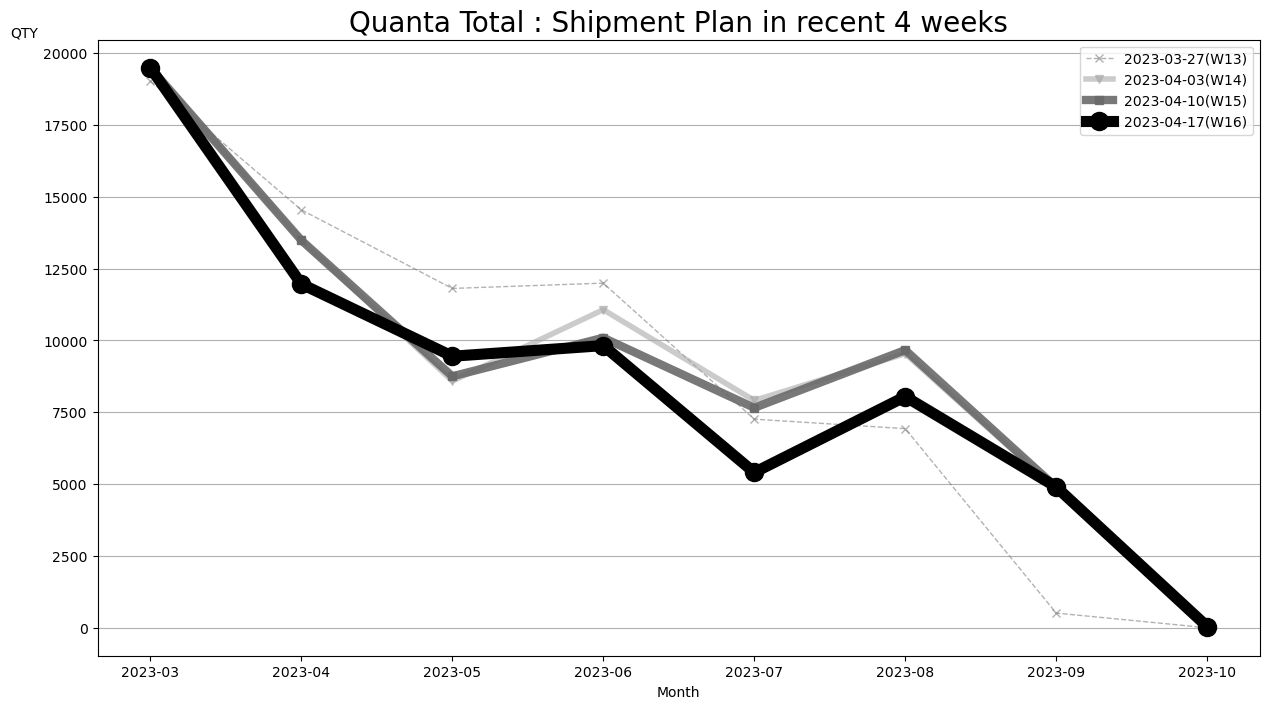

In [7]:
plot_forecast_change(df_fcst_ch, f'{vendor} Total : Shipment Plan in recent 4 weeks')

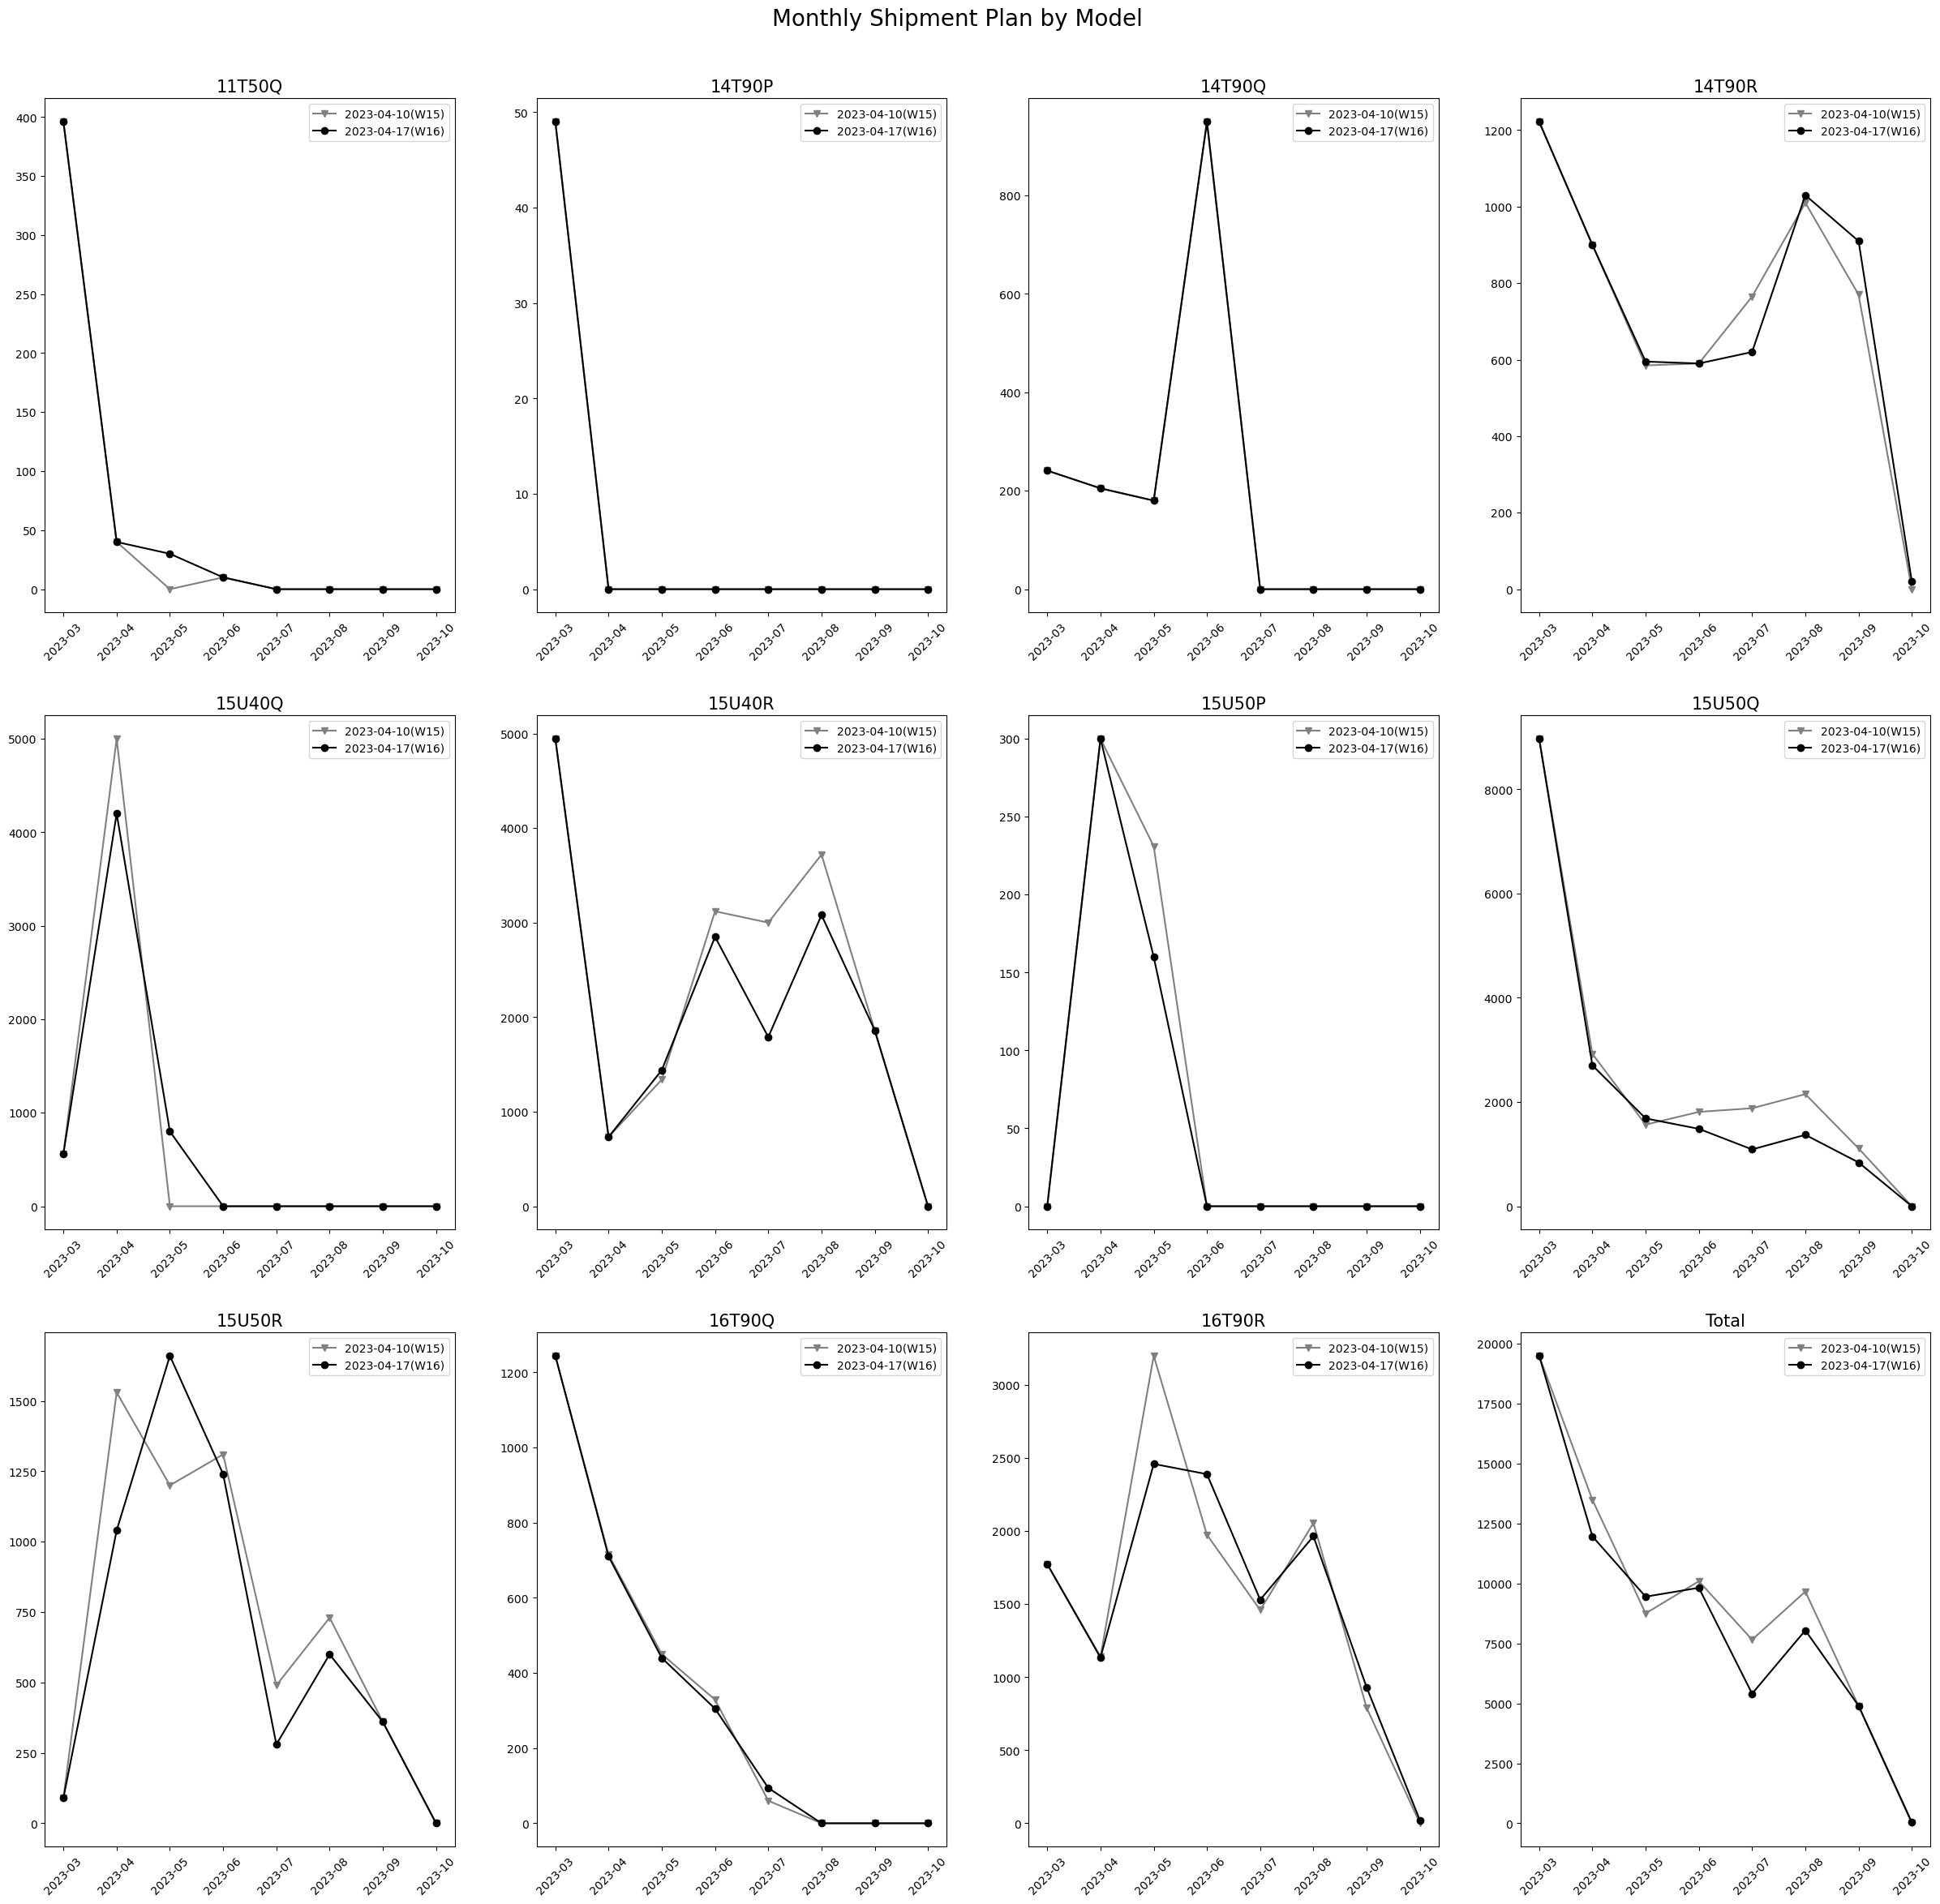

In [8]:
# 2-1) 전주대비 모델별 월별 합계 수량 차트 그리기
df_t = df_summary.groupby('Series').sum(numeric_only=True)
df_t.loc['Total'] = df_t.sum()
df_t = df_t[get_pattern_from_list(df_t, re.compile('^\d'))]

df_t1 = category_sum(qt_lastweek.groupby('Series').sum(numeric_only=True))
df_t1.loc['Total'] = df_t1.sum()


df_t2 = pd.DataFrame(data=0, index=df_t.index, columns=df_t.columns)

for i in df_t2.index:
    for j in df_t2.columns:
        try:
            sp_value = df_t1.loc[i, j]
        except:
            sp_value = 0
        df_t2.loc[i, j] = sp_value

lst = df_t.index.tolist()
a1 = len(lst) // 4
b1 = len(lst) % 4
if b1 != 0:
    a1 += 1

fig, axs = plt.subplots(a1, 4, figsize=(30, 28))
fig.suptitle('Monthly Shipment Plan by Model', fontsize=20, y=0.92)

for i, model in enumerate(lst):
    i1 = i // 4
    i2 = i % 4
    axs[i1, i2].plot(df_t2.columns, df_t2.loc[model].tolist(), color='grey', marker='v', label=lastweek)
    axs[i1, i2].plot(df_t.columns, df_t.loc[model].tolist(), marker='o', color='k', label=thisweek)
    axs[i1, i2].set_title(model, fontsize=15)
    axs[i1, i2].xaxis.set_tick_params(rotation=45)
    axs[i1, i2].legend()
plt.savefig('D:/figure/monthly_shipment_plan_by_model.png', bbox_inches='tight',pad_inches = 0)

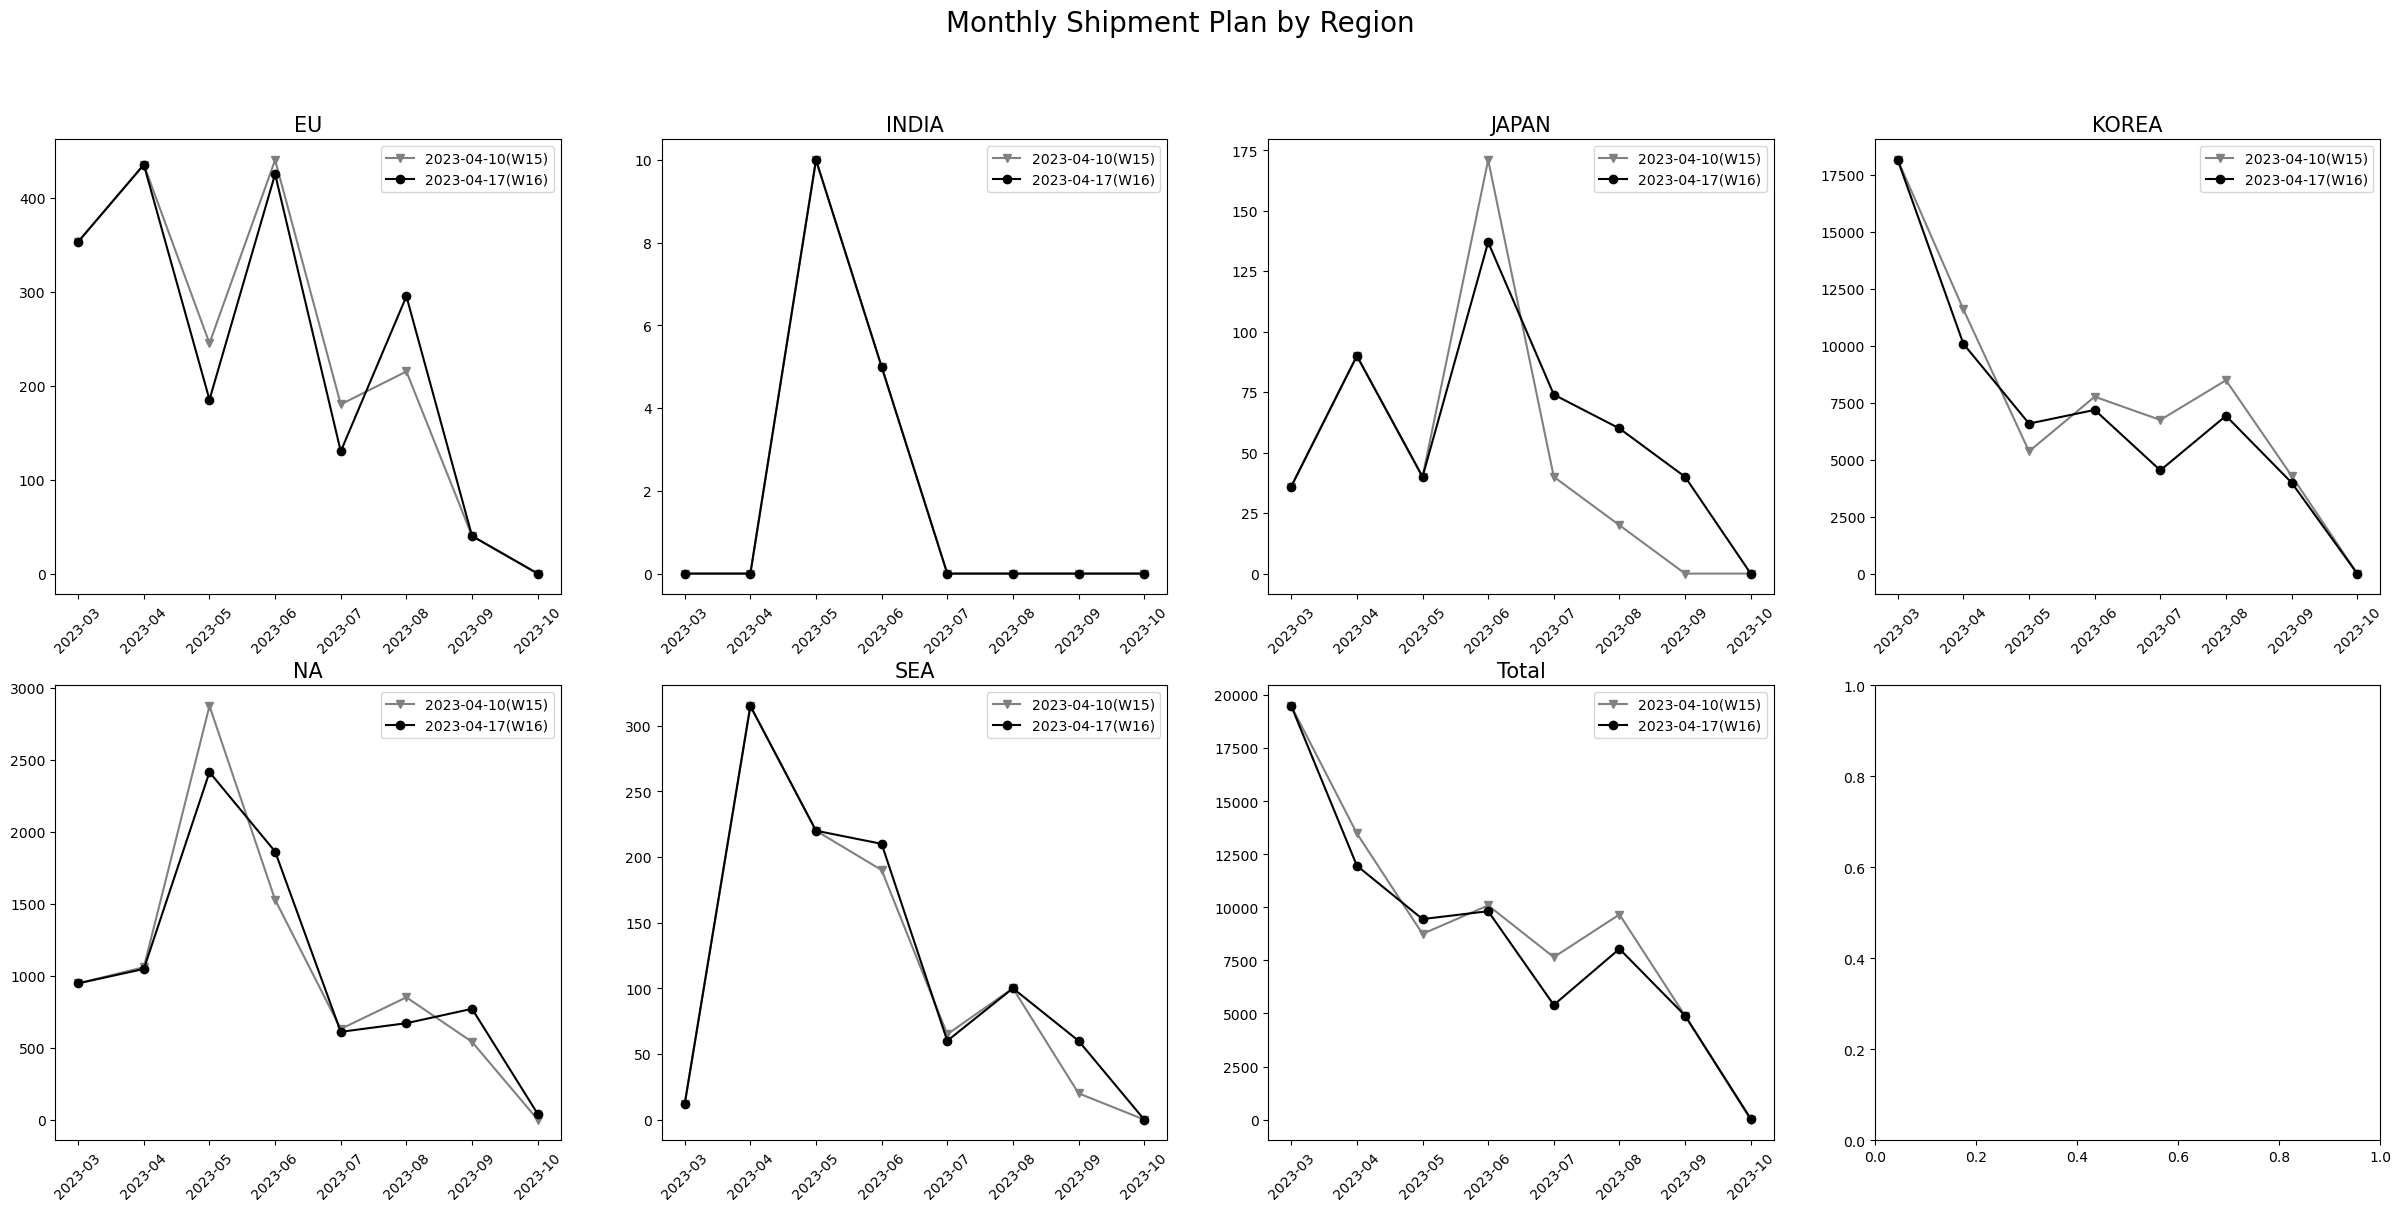

In [9]:
# 2-3) 전주대비 지역별 월별 수량 차트 그리기
df_t = df_summary.groupby('Region').sum(numeric_only=True)
df_t.loc['Total'] = df_t.sum()
df_t = df_t[get_pattern_from_list(df_t, re.compile('^\d'))]

df_t1 = category_sum(qt_lastweek.groupby('Region').sum(numeric_only=True))
df_t1.loc['Total'] = df_t1.sum()

df_t2 = pd.DataFrame(data=0, index=df_t.index, columns=df_t.columns)

for i in df_t2.index:
    for j in df_t2.columns:
        try:
            sp_value = df_t1.loc[i, j]
        except:
            sp_value = 0
        df_t2.loc[i, j] = sp_value

lst = df_t.index.tolist()
a1 = len(lst) // 4
b1 = len(lst) % 4
if b1 != 0:
    a1 += 1

fig, axs = plt.subplots(a1, 4, figsize=(30, 13))
fig.suptitle('Monthly Shipment Plan by Region', fontsize=20)

for i, region in enumerate(lst):
    i1 = i // 4
    i2 = i % 4
    axs[i1, i2].plot(df_t2.columns, df_t2.loc[region].tolist(), marker='v', color='grey', label=lastweek)
    axs[i1, i2].plot(df_t.columns, df_t.loc[region].tolist(), marker='o', color='k', label=thisweek)
    axs[i1, i2].set_title(region, fontsize=15)
    axs[i1, i2].xaxis.set_tick_params(rotation=45)
    axs[i1, i2].legend()
plt.savefig('D:/figure/monthly_shipment_plan_by_region.png', bbox_inches='tight',pad_inches = 0)

## 3. Forecast 구간에서 운영되는 SKU 수 확인

In [10]:
df_sku = qt_thisweek.groupby(['Series', 'Country'])['Mapping Model.Suffix'].count()
df_sku.name = thisweek
df_sku_lastweek = qt_lastweek.groupby(['Series', 'Country'])['Mapping Model.Suffix'].count()
df_sku_lastweek.name = lastweek
df_sku_count = pd.concat([df_sku, df_sku_lastweek], axis=1)
df_sku_count = df_sku_count.reset_index()
df_sku_count.insert(1, 'Vendor_Model', df_sku_count['Series'].replace(supplier_model_map))
df_sku_count.fillna(0, inplace=True)
df_sku_count = df_sku_count.convert_dtypes()

## 4. 현재 시점의 OPEN PO 현황 구하기

In [11]:
# OPEN PO 현황 구하기
open_po_df = get_open_po('Quanta').reset_index()
open_po =  pd.pivot_table(open_po_df, index=['Series', 'Mapping Model.Suffix', 'Country', 'PO No.', 'Unit Price'], columns='RSD Week Name', values='Open_Qty', aggfunc=sum).reset_index()
open_po.insert(0, 'Vendor_Model', open_po['Series'].replace(supplier_model_map))

## 5. 당월 기준 신규 확정 주차까지의 SP에 선적 결과와 PO 발행 현황 및 Quanta 생산계획과 비교

### 5-1) 금주 SP를 모델명으로 그룹핑함

In [12]:
df2 = qt_thisweek.groupby('Mapping Model.Suffix').sum(numeric_only=True)
df2 = df2[get_weeklist(df2.columns)]

### 5-2) 생산계획 가공

In [13]:
# 생산계획 가져와서 데이타 가공
with open('D:/Data/Quanta Input Plan.bin', 'rb') as f:
    df_input = pickle.load(f)
    
# Quanta 투입 모델에 해당하는 Country 정보를 Dictionary 로 만듬
temp_dic = {}
for model in qt_thisweek['Mapping Model.Suffix']:
    key = model
    value = '/'.join(set(qt_thisweek.groupby('Mapping Model.Suffix').get_group(model).loc[:,'Country'].tolist()))
    temp_dic[key] = value

issue_date = df_input['Created_at'].max().strftime('%Y-%m-%d') # Input 계획 배포일 최신날짜로 설정
print(f'Updated on : {issue_date}')
df_input = df_input[df_input['Created_at'].astype(str).str.contains(issue_date)]
df_input['Day Name'] = df_input['Input Date'].dt.day_name()
df_input['Day'] = df_input['Input Date'].dt.day
df_input['Series'] = df_input['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model)
df_input.insert(1, 'Country', df_input['Mapping Model.Suffix'].replace(make_dict_from_df(get_pdr()[['Model.Suffix', 'Nation']])))
qt_input_plan = pd.pivot_table(df_input, index=['Series', 'Country', 'Mapping Model.Suffix', 'Quanta P/N'], columns=['LG Week', 'Day', 'Day Name'], values='QTY', aggfunc=sum).fillna(0)

Updated on : 2023-04-20


In [14]:
input_total = df_input.groupby('Mapping Model.Suffix')['QTY'].sum()
input_total.name = 'Input Plan'
# input_total['Sum'] = input_total.sum()
actual_input = pd.Series(dtype=int)
actual_input.name = 'Actual Input'
for grp in df_input.groupby('Mapping Model.Suffix'):
    cond = (grp[1]['Input Date'] <= issue_date)
    actual_input.loc[grp[0]] = grp[1][cond]['QTY'].sum()
# actual_input['Sum'] = actual_input.sum()
df_input_sum = pd.concat([input_total, actual_input], axis=1)
df_input_sum['Balance'] = df_input_sum['Input Plan'] - df_input_sum['Actual Input']

### 5-3) 금주 기준 SP에 전월까지 SP 실적 및 생산 현황, PO 현황 만들기

In [15]:
dfi = df_input.groupby(['Mapping Model.Suffix', 'LG Week'])['QTY'].sum()

year_lastmonth, last_month = get_lastmonth(thisweek)
thismonth_wklist = get_weeklist_for_certain_month(today.isocalendar()[0], get_month_from_date(today))
pastweek = get_weeklist_for_certain_month(year_lastmonth, last_month) + thismonth_wklist[:thismonth_wklist.index(thisweek)] # 금주 기준 이전주차의 리스트
# weeklist = pastweek + [get_weekname_from(thisweek, i) for i in range(frozen+1)] #  금주 기준 확정주차 포함 전체 Weeklist 만듬
weeklist = []
i = 1
wkname = thisweek
weeklist.append(wkname)
while wkname != get_weekname_from(df_input['LG Week'].max(), 1):
    wkname = get_weekname_from(wkname, i)
    weeklist.append(wkname)
weeklist = pastweek + weeklist
col1 = ['Input']*3 + weeklist + ['Total']
col2 = ['Plan', 'Actual', 'Balance'] + ['SP']*len(weeklist) + ['SP']
with open('D:/Data/Quanta shipment result DB.bin', 'rb') as f:
    SR_df = pickle.load(f)

# 새로운 Dataframe에 관련 데이타를 가져와서 전체 취합
df3 = pd.DataFrame(data=0, index=df2.index, columns=[col1, col2]) # 인덱스만 멀티인덱스컬럼 설정 후 데이타는 0으로 데이터프레임 생성

# 각 모델의 전체 투입수량/실적/잔량 기입
for model in df_input_sum.index:
    df3.loc[model, ('Input', 'Plan')] = df_input_sum.loc[model, 'Input Plan']
    df3.loc[model, ('Input', 'Actual')] = df_input_sum.loc[model, 'Actual Input']
    df3.loc[model, ('Input', 'Balance')] = df_input_sum.loc[model, 'Balance']

# 각 모델의 주차별 투입수량 기입
for i, j in dfi.index:
    df3.loc[i, (j, 'Input')] = dfi.loc[(i,j)]

# 각 모델의 주차별 선적실적, Open PO 수량 기입 
for week in weeklist:
    if week < thisweek:
        for model in df2.index:
            qty1 = SR_df.loc[(SR_df['Mapping Model.Suffix'] == model) & (SR_df['Week Name'] == week), 'Ship'].sum()
            df3.loc[model, (week, 'SP')] = qty1
    if week == thisweek:
        for model in df2.index:
            qty1 = open_po_df.loc[(open_po_df['Mapping Model.Suffix']==model) & (open_po_df['RSD Week Name'] < week), 'Open_Qty'].sum() # 이번주 제외한 과거주차 RSD의 Open PO 수량
            qty2 = open_po_df.loc[(open_po_df['Mapping Model.Suffix']==model) & (open_po_df['RSD Week Name'] == week), 'Open_Qty'].sum() # 이번주 RSD의 Open PO 수량
            qty3 = SR_df.loc[(SR_df['Mapping Model.Suffix'] == model) & (SR_df['Week Name'] == week), 'Ship'].sum() # 이번주 선적한 SP값(Pre ship된 수량도 포함되어 있을 수 있음)
            df3.loc[model, (week, 'PO_carry over')] = qty1
            df3.loc[model, (week, 'Open_PO')] = qty2
            df3.loc[model, (week, 'Shipped')] = qty3
            df3.loc[model, (week, 'SP')] = df2.loc[model, week]
    if week > thisweek:
        for model in df2.index:
            qty1 = open_po_df.loc[(open_po_df['Mapping Model.Suffix']==model) & (open_po_df['RSD Week Name'] == week), 'Open_Qty'].sum()
            df3.loc[model, (week, 'Open_PO')] = qty1
            df3.loc[model, (week, 'SP')] = df2.loc[model, week]

# 만약 금주 실 선적 수량 중 미래 구간의 Pre ship 이 있으면 미래 구간의 SP에서 Pre ship 수량만큼 차감하고, 해당 Pre ship 수량을 금주 SP와 shipped에 각각 추가
c1 = (SR_df['Week Name'] == thisweek)
c2 = (SR_df['RSD Week Name'] > thisweek)
c3 = (SR_df['Cancel'] == 'N')
if SR_df[c1 & c2 & c3].shape[0] > 0:
    print('Pre-Ship Exists.')
    print(SR_df[c1 & c2 & c3].groupby(['Mapping Model.Suffix', 'Ship To', 'RSD Week Name'])['Ship'].sum())
    for i in SR_df[c1 & c2 & c3].iterrows():
        df3.loc[i[1]['Mapping Model.Suffix'], (i[1]['RSD Week Name'], 'SP')] = df3.loc[i[1]['Mapping Model.Suffix'], (i[1]['RSD Week Name'], 'SP')] - i[1]['Ship'] # Pre-Ship 수량만큼 해당 미래구간 SP값을 차감 
        df3.loc[i[1]['Mapping Model.Suffix'], (i[1]['Week Name'], 'SP')] += i[1]['Ship'] # 금주 SP에 Pre ship 수량만큼 증량

# 이번달의 SP 합계를 구할 컬럼만 리스트로 만듬
col_list = []
for week in thismonth_wklist[:thismonth_wklist.index(thisweek)] + [get_weekname_from(thisweek, i) for i in range(frozen+1)]:
    col_list.append((week, 'SP'))

for model in df3.index:
    for col in col_list:
        df3.loc[model, ('Total', 'SP')] = df3.loc[model, ('Total', 'SP')] + df3.loc[model, col]

# 이번달의 금일 기준 모델별 선적 실적 합계를 붙이기
sp_total = SR_df[(SR_df['Ship Year'] == int(f'{today.isocalendar()[0]}'))
               & (SR_df['Ship Month'] == int(f'{get_month_from_date(today):02d}'))].groupby('Mapping Model.Suffix')['Ship'].sum()
sp_total.name = ('Total', 'Shipment')
df3 = df3.join(sp_total)

Pre-Ship Exists.
Mapping Model.Suffix  Ship To  RSD Week Name  
15UD40R-G.AX36K       EKHQ     2023-04-24(W17)    60.0
16T90R-G.AA76K        EKHQ     2023-04-24(W17)     8.0
Name: Ship, dtype: float64


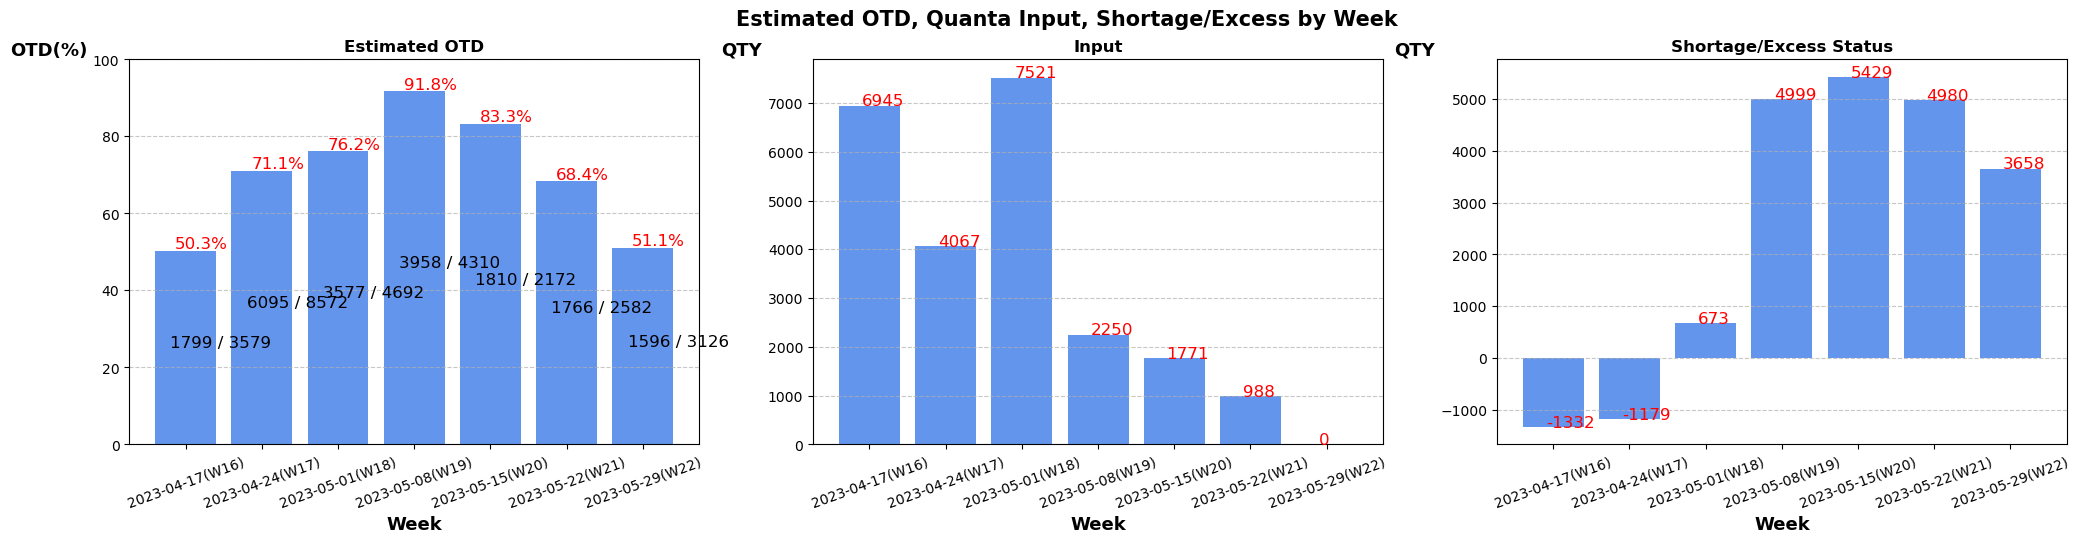

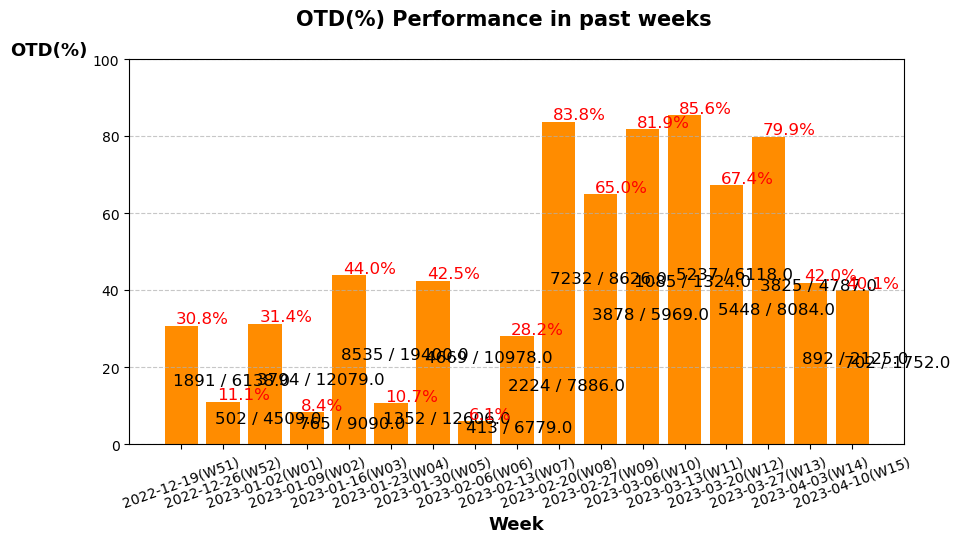

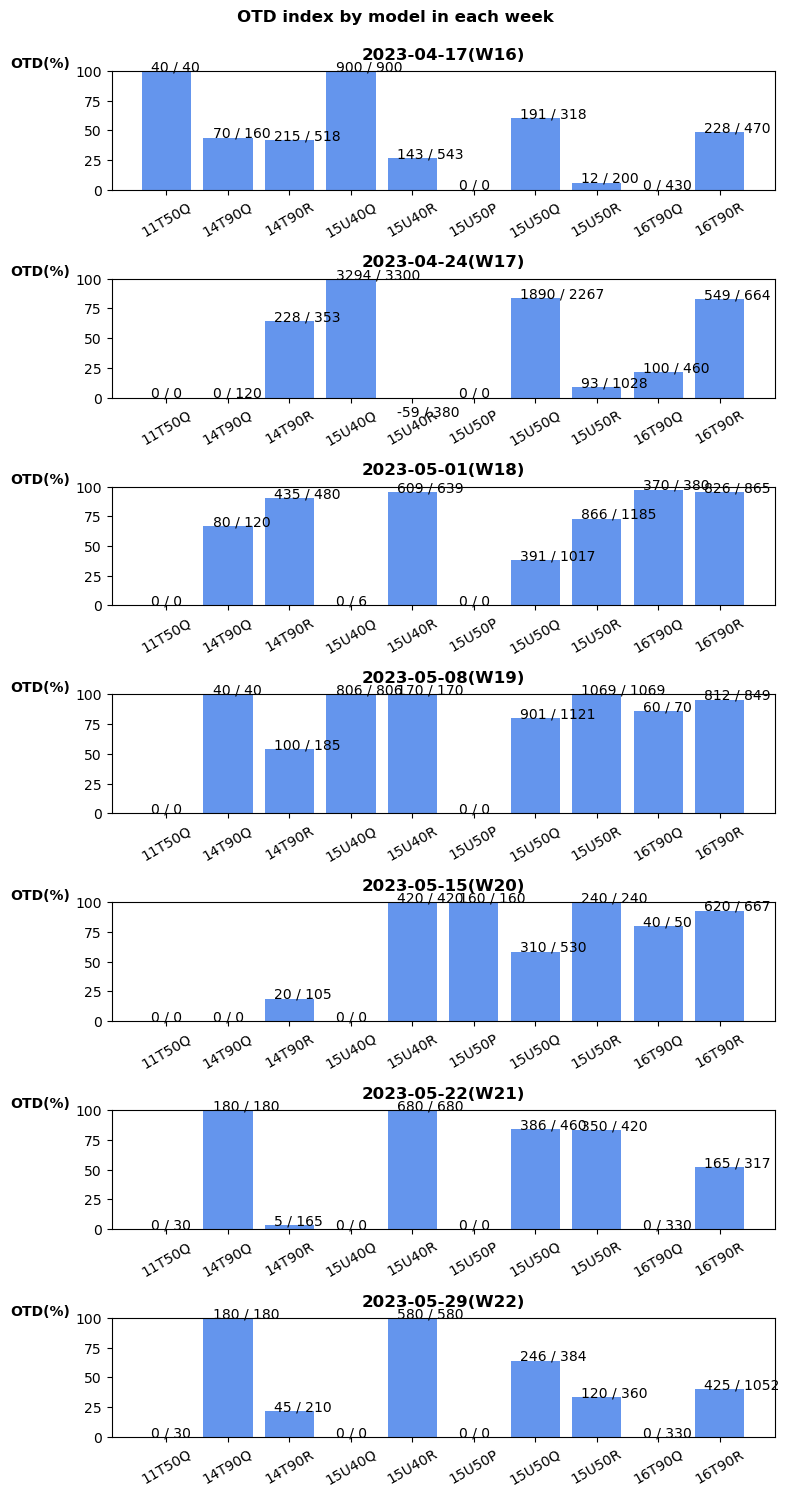

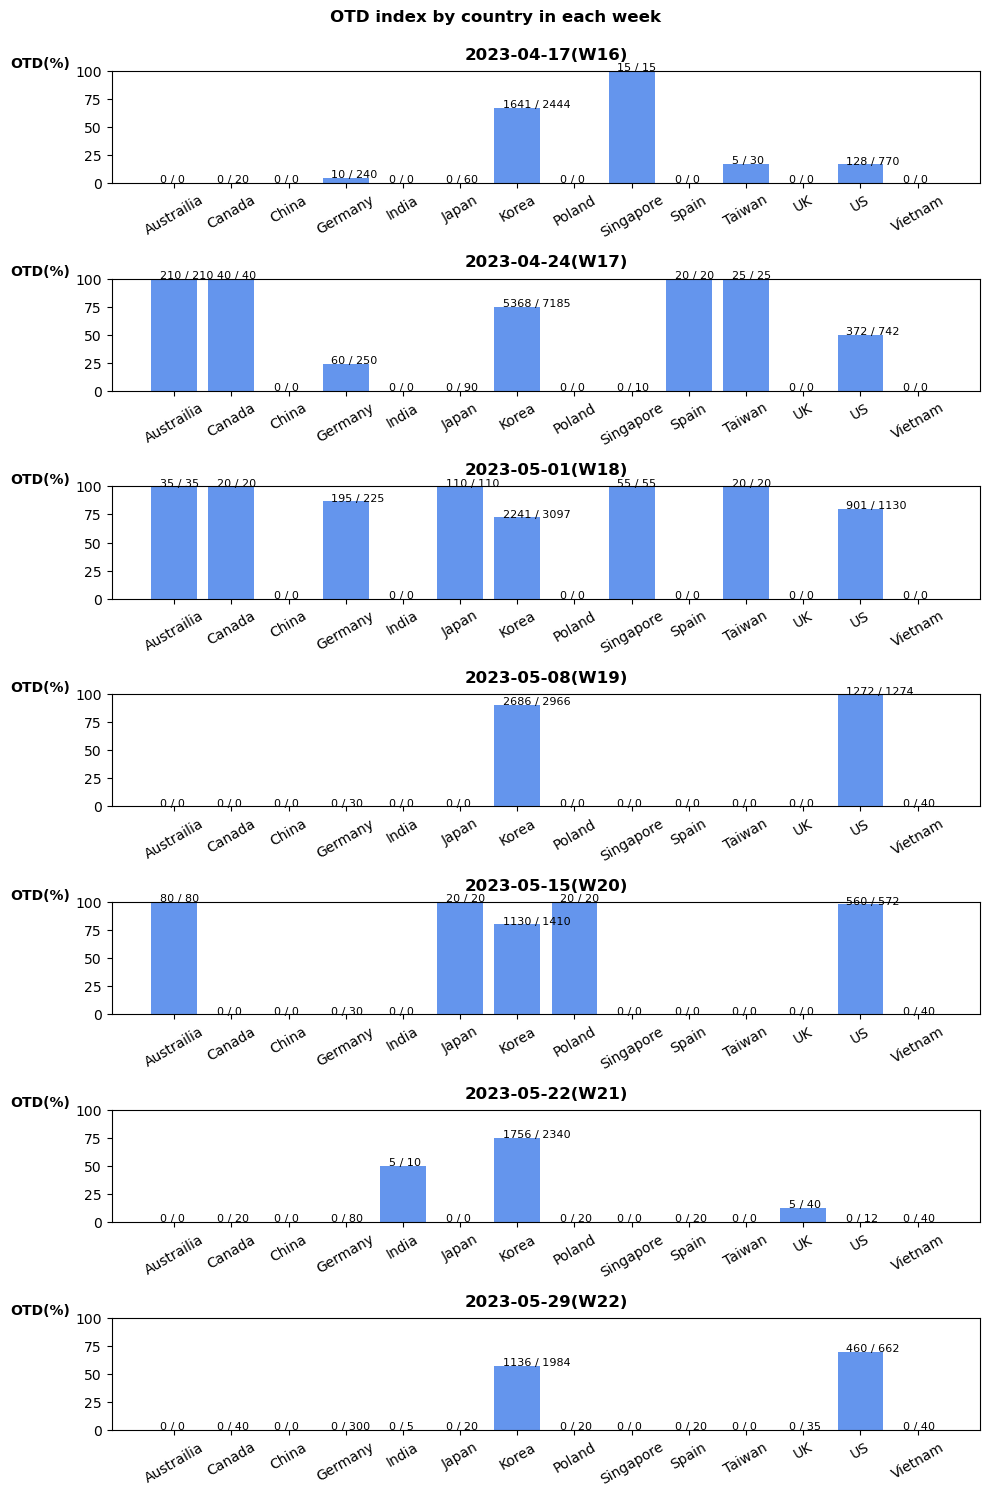

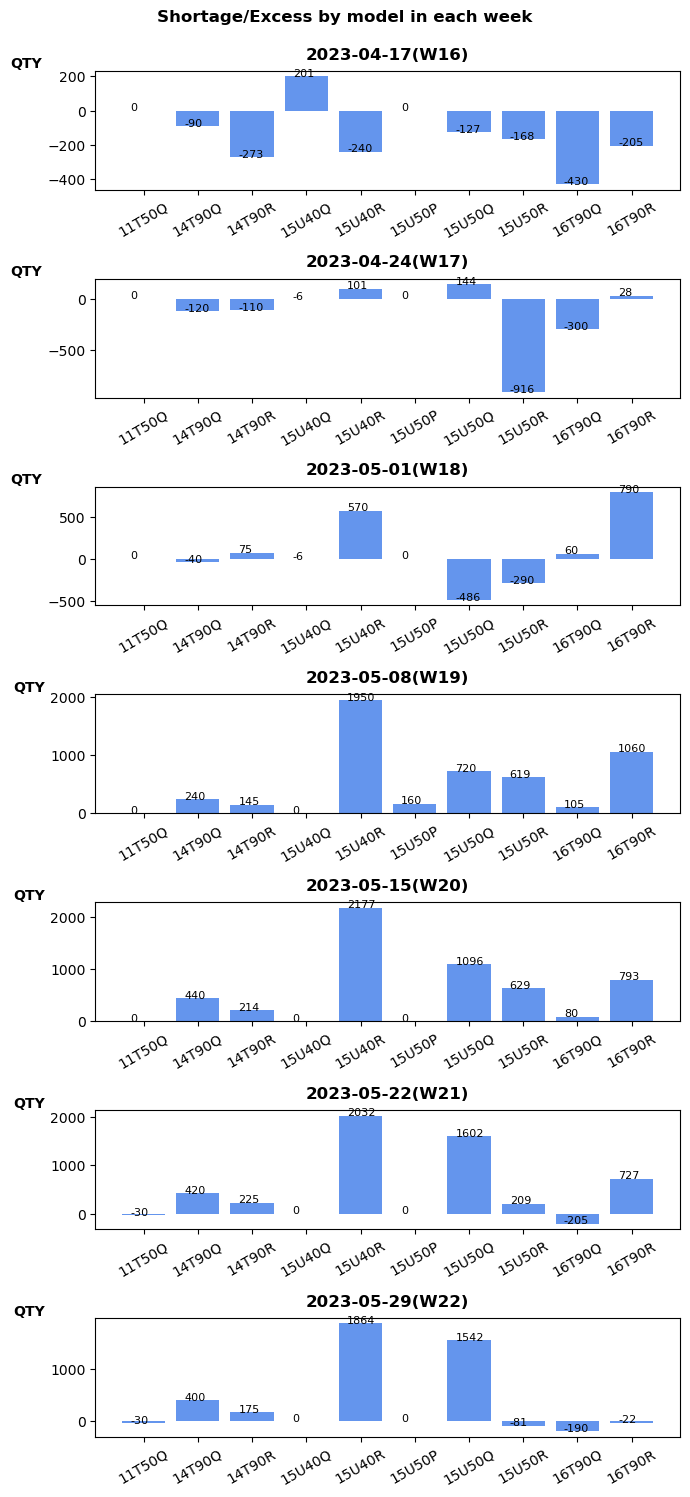

In [16]:
otd = make_otd_raw_data(df3.copy()) # OTD dashboard 작성할 데이타프레임으로 copy
otd = otd.reset_index().set_index(['Series', 'Country', 'Mapping Model.Suffix']).stack(level=0)
otd.index.names = ['Series', 'Country', 'Mapping Model.Suffix', 'Week']
otd = otd.convert_dtypes()
otd = otd[['BOH', 'SP', 'CO', 'Input', 'SP(Estimated)', 'OTD(Estimated)', 'Shortage/Excess']]

# 주차별 예상 OTD(%) 막대 그래프 표시
otd_by_week = otd.groupby(['Week'])[['BOH', 'SP', 'CO', 'SP(Estimated)']].sum()
otd_by_week = otd_by_week[thisweek:]
otd_by_week['OTD(Estimated)'] = otd_by_week['SP(Estimated)'] / (otd_by_week['SP'] + otd_by_week['CO']) * 100
otd_by_week['OTD(Estimated)'] = otd_by_week['OTD(Estimated)'].apply(lambda x:round(x, 1))

# 각 주차별 input 수량 막대 그래프 표시
input_by_week = otd.groupby('Week')['Input'].sum()[thisweek:]
input_by_week.name = 'Input Qty'

# 각 주차별 shortage 수량 막대 그래프 표시
shortage_by_week = otd.groupby('Week')['Shortage/Excess'].sum()[thisweek:]

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
fig.suptitle('Estimated OTD, Quanta Input, Shortage/Excess by Week', fontweight='bold', size=15)

ax[0].set_title('Estimated OTD', y=1, fontweight='bold')
bar = ax[0].bar(otd_by_week.index, otd_by_week['OTD(Estimated)'], color='cornflowerblue')
ax[0].grid(axis='y', alpha=0.7, linestyle='--')
ax[0].set_xlabel('Week', loc='center', fontweight='bold', size=13)
ax[0].set_ylabel('OTD(%)', rotation=0, loc='top', fontweight='bold', size=13)
ax[0].set_ylim([0, 100])
ax[0].tick_params(axis='x', rotation=20)
for idx, rect in enumerate(bar):
    ax[0].text(idx-0.14, rect.get_height()+0.5, f"{otd_by_week['OTD(Estimated)'][idx]}%", c='r', size=12)
    ax[0].text(idx-0.2, rect.get_height()/2, f"{otd_by_week['SP(Estimated)'][idx]} / {(otd_by_week['SP'] + otd_by_week['CO'])[idx]}", size=12)

ax[1].set_title('Input', y=1, fontweight='bold')
bar = ax[1].bar(input_by_week.index, input_by_week, color='cornflowerblue')
ax[1].grid(axis='y', alpha=0.7, linestyle='--')
ax[1].set_xlabel('Week', loc='center', fontweight='bold', size=13)
ax[1].set_ylabel('QTY', rotation=0, loc='top', fontweight='bold', size=13)
ax[1].tick_params(axis='x', rotation=20)
for idx, rect in enumerate(bar):
    ax[1].text(idx-0.1, rect.get_height(), input_by_week[idx], c='r', size=12)

ax[2].set_title('Shortage/Excess Status', y=1, fontweight='bold')
bar = ax[2].bar(shortage_by_week.index, shortage_by_week, color='cornflowerblue')
ax[2].grid(axis='y', alpha=0.7, linestyle='--')
ax[2].set_xlabel('Week', loc='center', fontweight='bold', size=13)
ax[2].set_ylabel('QTY', rotation=0, loc='top', fontweight='bold', size=13)
ax[2].tick_params(axis='x', rotation=20)
for idx, rect in enumerate(bar):
    ax[2].text(idx-0.1, rect.get_height(), shortage_by_week[idx], c='r', size=12)
plt.savefig('D:/figure/Estimated OTD, Input, Shortage, Excess by week.png', bbox_inches='tight',pad_inches = 0)

with open('D:/Data/OTD_result_db.bin', 'rb') as f:
    otd_result = pickle.load(f)

otd_result_week = otd_result.pivot_table(['Target', 'Ship'], index='Ref', aggfunc=sum)
otd_result_week['OTD(Result)'] = round(otd_result_week['Ship'] / otd_result_week['Target'] * 100, 1)

fig, axes = plt.subplots(1,1, figsize=(10, 5))
fig.suptitle('OTD(%) Performance in past weeks', fontweight='bold', size=15)
bar = axes.bar(otd_result_week.index, otd_result_week['OTD(Result)'], color='darkorange')
axes.grid(axis='y', alpha=0.7, linestyle='--')
axes.set_xlabel('Week', fontweight='bold', size=13)
axes.set_ylabel('OTD(%)', loc='top', rotation=0, fontweight='bold', size=13)
axes.set_ylim([0, 100])
axes.tick_params(axis='x', rotation=20)
for idx, rect in enumerate(bar):
    axes.text(idx-0.14, rect.get_height()+0.5, f"{otd_result_week['OTD(Result)'][idx]}%", c='r', size=12)
    axes.text(idx-0.2, rect.get_height()/2, f"{otd_result_week['Ship'][idx]} / {otd_result_week['Target'][idx]}", size=12)
plt.savefig('D:/figure/OTD result in last weeks.png', bbox_inches='tight',pad_inches = 0)

# 각 주차의 모델별 예상 OTD 막대그래프 그리기
otd_by_model = otd.groupby(['Week', 'Series'])[['BOH', 'SP', 'CO', 'Input', 'SP(Estimated)']].sum()[thisweek:]
otd_by_model['OTD(Estimated)'] = round(otd_by_model['SP(Estimated)'] / (otd_by_model['SP'] + otd_by_model['CO']) * 100, 1) # 주의) 계산결과에는 0 으로 나누는 경우, 0을 0으로 나누는 경우가 있을 수 있음
otd_by_model['OTD(Estimated)'].loc[np.isnan(otd_by_model['OTD(Estimated)'])] = 0  # 위의 나누기 계산 중 0 / 0 일 때 np.NaN 인데, 데이터 타입이 Int64는 null 값으로 인식하지 못하는 오류가 있는 듯. 그래서 np.isnan 을 통해 해당값을 0 으로 별도 변경

fig, ax = plt.subplots(len(otd_by_model.groupby('Week')), figsize=(8, 15), tight_layout=True)
fig.suptitle('OTD index by model in each week', fontweight='bold', y=0.995)

for idx, grp in enumerate(otd_by_model.groupby('Week')):
    temp = otd_by_model.loc[grp[0]]
    ax[idx].set_title(grp[0], y=1.03, fontweight='bold')
    ax[idx].tick_params(axis='x', rotation=30)
    ax[idx].set_ylim([0, 100])
    ax[idx].set_ylabel('OTD(%)', rotation=0, loc='top', fontweight='bold')
    bar = ax[idx].bar(temp.index, temp['OTD(Estimated)'], color='cornflowerblue')
    for i, rect in enumerate(bar):
        ax[idx].text(i-0.25, rect.get_height()+0.2, f"{temp['SP(Estimated)'][i]} / {temp['SP'][i] + temp['CO'][i]}", size=10)
plt.savefig('D:/figure/Estimated OTD index by model.png', bbox_inches='tight',pad_inches = 0)

otd_by_country = otd.groupby(['Week', 'Country'])[['BOH', 'SP', 'CO', 'Input', 'SP(Estimated)', 'OTD(Estimated)']].sum()[thisweek:]
otd_by_country['OTD(Estimated)'] = round(otd_by_country['SP(Estimated)'] / (otd_by_country['SP'] + otd_by_country['CO']) * 100, 1) # 주의) 계산결과에는 0 으로 나누는 경우, 0을 0으로 나누는 경우가 있을 수 있음
otd_by_country['OTD(Estimated)'].loc[np.isnan(otd_by_country['OTD(Estimated)'])] = 0 # 위의 나누기 계산 중 0 / 0 일 때 np.NaN 인데, 데이터 타입이 Int64는 null 값으로 인식하지 못하는 오류가 있는 듯. 그래서 np.isnan 을 통해 해당값을 0 으로 별도 변경

fig, ax = plt.subplots(len(otd_by_country.groupby('Week')), figsize=(10, 15), tight_layout=True)
fig.suptitle('OTD index by country in each week', fontweight='bold', y=0.995)

for idx, grp in enumerate(otd_by_country.groupby('Week')):
    temp = otd_by_country.loc[grp[0]]
    ax[idx].set_title(grp[0], y=1.03, fontweight='bold')
    ax[idx].tick_params(axis='x', rotation=30)
    ax[idx].set_ylim([0, 100])
    ax[idx].set_ylabel('OTD(%)', rotation=0, loc='top', fontweight='bold')
    bar = ax[idx].bar(temp.index, temp['OTD(Estimated)'], color='cornflowerblue')
    for i, rect in enumerate(bar):
        ax[idx].text(i-0.25, rect.get_height()+0.2, f"{temp['SP(Estimated)'][i]} / {temp['SP'][i] + temp['CO'][i]}", size=8)
plt.savefig('D:/figure/Estimated OTD index by country.png', bbox_inches='tight',pad_inches = 0)

shortage_by_model = otd.groupby(['Week', 'Series'])['Shortage/Excess'].sum()[thisweek:]

fig, ax = plt.subplots(len(shortage_by_model.groupby('Week')), figsize=(7, 15), tight_layout=True)
fig.suptitle('Shortage/Excess by model in each week', fontweight='bold', y=0.995)

for idx, grp in enumerate(shortage_by_model.groupby('Week')):
    temp = shortage_by_model.loc[grp[0]]
    ax[idx].set_title(grp[0], y=1.03, fontweight='bold')
    ax[idx].tick_params(axis='x', rotation=30)
    ax[idx].set_ylabel('QTY', rotation=0, loc='top', fontweight='bold')
    bar = ax[idx].bar(temp.index, temp, color='cornflowerblue')
    for i, rect in enumerate(bar):
        ax[idx].text(i-0.25, rect.get_height(), temp[i], size=8)
plt.savefig('D:/figure/Shortage_Excess by model.png', bbox_inches='tight',pad_inches = 0)

otd = otd.reset_index()
excess_list = list(otd.loc[(otd['Week'] == otd['Week'].max()) & (otd['Shortage/Excess'] > 0), 'Mapping Model.Suffix'].values)
otd['Color'] = otd['Mapping Model.Suffix'].map(make_dict_from_df(get_pdr()[['Model.Suffix', '1.2 SET COLOR']]))
est_sp_by_series = otd.pivot_table(values=['SP', 'BOH', 'CO', 'Input', 'SP(Estimated)'], index='Series', columns='Week', aggfunc='sum').swaplevel(0, 1, 1).sort_index(axis=1)
est_sp_by_suffix = otd.pivot_table(values=['SP', 'BOH', 'CO', 'Input', 'SP(Estimated)'], index=['Series', 'Mapping Model.Suffix', 'Country', 'Color'], columns='Week', aggfunc='sum').swaplevel(0, 1, 1).sort_index(axis=1)
excess_suffix = otd[otd['Mapping Model.Suffix'].isin(excess_list)].pivot_table(values=['BOH', 'SP', 'CO', 'Input', 'SP(Estimated)'], index=['Series', 'Mapping Model.Suffix', 'Country', 'Color'], columns='Week', aggfunc='sum').swaplevel(0, 1, 1).sort_index(axis=1)

In [17]:
df3.sort_index(axis=1, inplace=True)
df3 = df3.reset_index()
df3.insert(0, 'Series', df3['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model))
df3.insert(1, 'Country', df3['Mapping Model.Suffix'].replace(temp_dic).replace(make_dict_from_df(get_pdr()[['Model.Suffix', '1.2 SET COLOR']])))
df3.insert(1, 'Vendor_Model', df3['Series'].replace(supplier_model_map))
df3['Input', 'Gap'] = df3['Input', 'Plan'] - df3['Total', 'SP']

df3 = df3.replace({0:np.nan})
df3 = df3.set_index(['Series', 'Vendor_Model', 'Country', 'Mapping Model.Suffix'])
df3 = df3.dropna(how='all')
df3 = df3.reset_index()
df3 = df3.fillna(0)
df3 = df3.convert_dtypes()

SR_df = SR_df.reset_index()
cond1 = SR_df['Week Name'].isin(weeklist)
shipment_list = SR_df[cond1].pivot_table('Ship', index=['Region', 'Country', 'PO No.', 'BL No', 'Ship Date', 'Mapping Model.Suffix', 'Unit Price', 'RSD Week Name'],
                  columns='Week Name', aggfunc=sum).fillna(0).reset_index()
shipment_list['Ship Date'] = shipment_list['Ship Date'].dt.date

### 5-4) 데이타 시각화

In [18]:
df4 = df3.groupby(['Series', 'Country']).sum(numeric_only=True).droplevel(0, axis=1).iloc[:,-6:][['SP', 'Plan', 'Actual', 'Shipment']].reset_index()
df4.rename({'SP':'LG Plan', 'Plan':'Input Plan', 'Actual':'Input Finished', 'Shipment':'Ship Result'}, axis=1, inplace=True)

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_19052\2430376306.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df4 = df3.groupby(['Series', 'Country']).sum(numeric_only=True).droplevel(0, axis=1).iloc[:,-6:][['SP', 'Plan', 'Actual', 'Shipment']].reset_index()


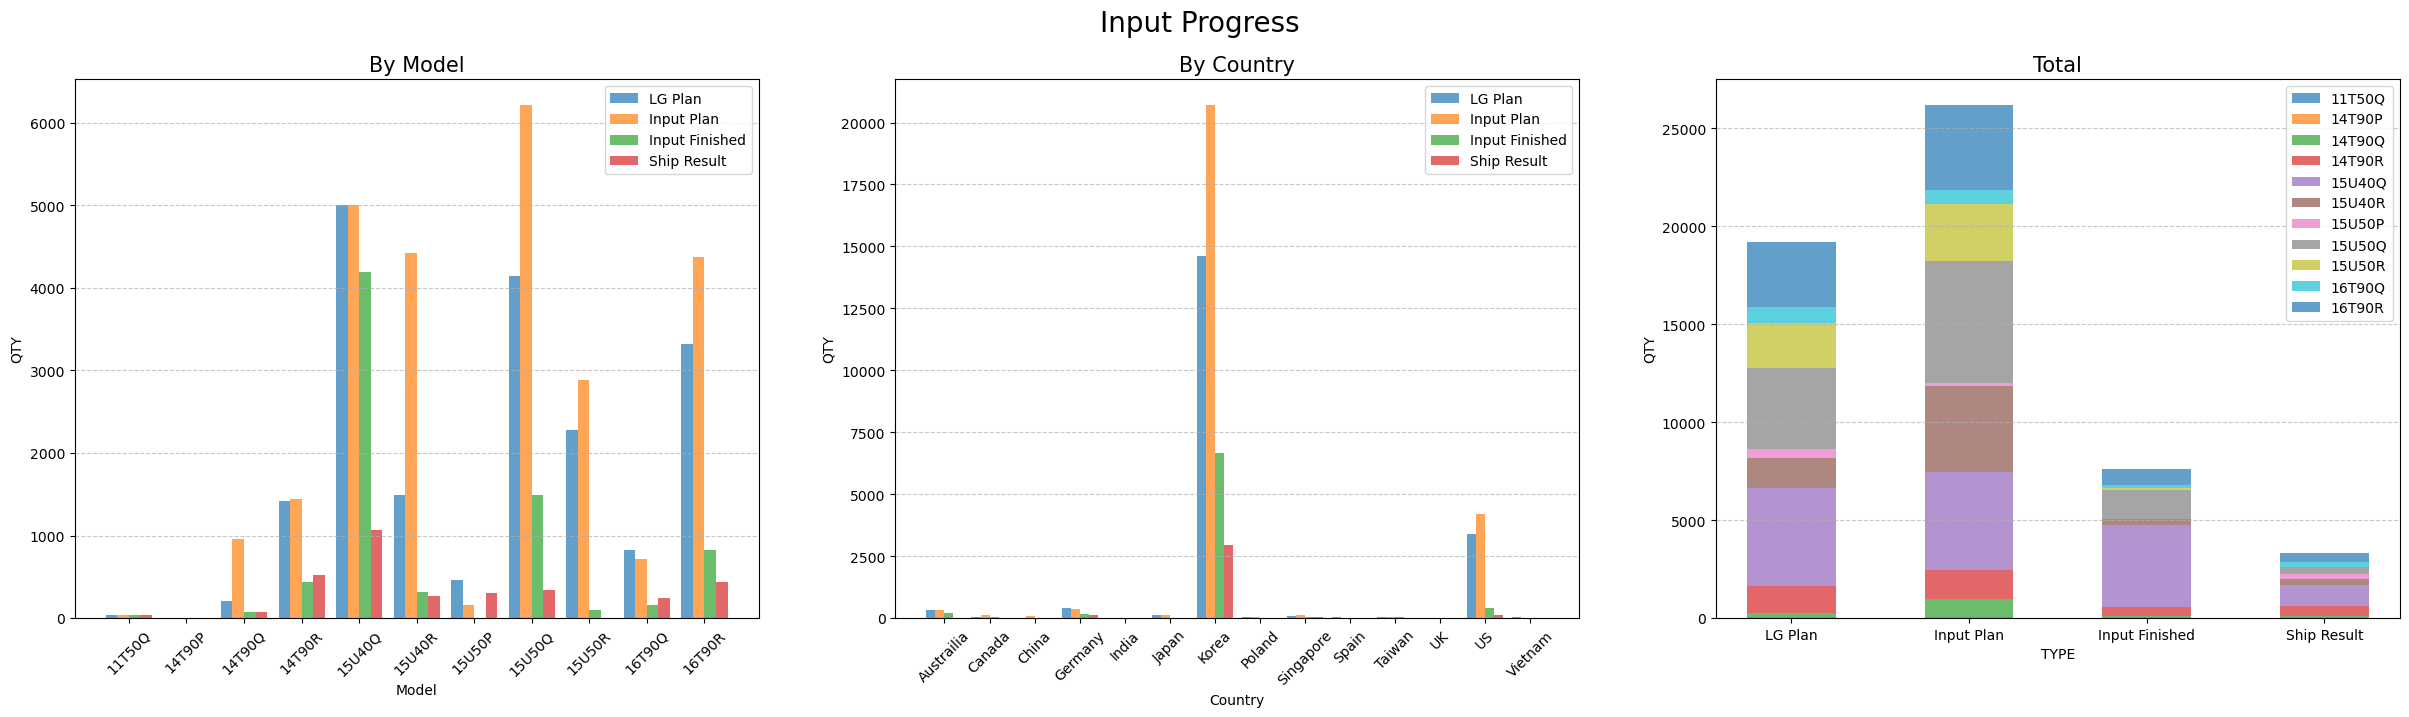

In [19]:
fig, axs = plt.subplots(1,3, figsize=(30,7))
fig.suptitle('Input Progress', fontsize=20)
df_model = df4.groupby('Series')[['LG Plan', 'Input Plan', 'Input Finished', 'Ship Result']].sum()
df_country = df4.groupby('Country')[['LG Plan', 'Input Plan', 'Input Finished', 'Ship Result']].sum()
x1 = np.arange(df_model.shape[0])
x2 = np.arange(df_country.shape[0])
width = [-0.3, -0.1, 0.1, 0.3]
for w, item in zip(width, df_model.columns):
    axs[0].bar(x1+w, df_model[item], width=0.2, label=item, alpha=0.7)

for w, country in zip(width, df_country.columns):
    axs[1].bar(x2+w, df_country[country], width=0.2, label=country, alpha=0.7)

btm = pd.Series(0, index=['LG Plan', 'Input Plan', 'Input Finished', 'Ship Result'])
for model in df_model.index:
    axs[2].bar(df_model.columns, df_model.loc[model, df_model.columns], width=0.5, bottom=btm, label=model, alpha=0.7)
    btm = btm + df_model.loc[model, :]

axs[0].set_title('By Model', fontsize=15)
axs[0].set(xlabel='Model', ylabel='QTY')
axs[0].set_xticks(x1)
axs[0].set_xticklabels(df_model.index, rotation=45)
axs[0].grid(axis='y', alpha=0.7, linestyle='--')
axs[0].legend()

axs[1].set_title('By Country', fontsize=15)
axs[1].set(xlabel='Country', ylabel='QTY')
axs[1].set_xticks(x2)
axs[1].set_xticklabels(df_country.index, rotation=45)
axs[1].grid(axis='y', alpha=0.7, linestyle='--')
axs[1].legend()

axs[2].set_title('Total', fontsize=15)
axs[2].set(xlabel='TYPE', ylabel='QTY')
axs[2].set_xticks(df_model.columns)
axs[2].grid(axis='y', alpha=0.7, linestyle='--')
axs[2].legend()

plt.savefig('D:/figure/Input progress.png', bbox_inches='tight',pad_inches = 0)

## 6. PDR 정보를 가져와 SP에 Merge함

In [20]:
pdr_df = get_pdr()
pdr_df = pdr_df[['Model.Suffix','BASE UNIT', '1.2 SET COLOR', '1.1 MAIN BOARD', 'LCD ASSY', 'KEYBOARD',
                 '3.0 CPU LABEL', 'PEN', 'FINGER PRINT', 'SSD', 'OS TYPE', 'BATTERY']]
pdr_df = pdr_df.rename(columns={'Model.Suffix':'Mapping Model.Suffix', '1.2 SET COLOR':'Color',
                                '1.1 MAIN BOARD':'MAIN BOARD', 'LCD ASSY':'LCD', '3.0 CPU LABEL':'CPU'})
qt_thisweek = pd.merge(qt_thisweek, pdr_df, how='left')
qt_thisweek = pd.concat([qt_thisweek[pd.Series(qt_thisweek.columns)[~pd.Series(qt_thisweek.columns).str.contains('\d\d-\d\d')]], qt_thisweek[get_weeklist(qt_thisweek.columns)]], axis=1)

## 7. 최종 결과물을 엑셀파일로 생성

In [21]:
# 정확한 파일명 생성을 위해 하기 변수값 확인
week_num = today.isocalendar()[1] # 이번주의 주차숫자(Week Number)를 구함
update_time = datetime.datetime.now().strftime('%y%m%d%H')

file_name = f"{update_time}_W{week_num}_Quanta_weekly_forecast_{ver1}.xlsx" #이번주 forecast 파일을 저장할 이름 설정

with pd.ExcelWriter("D:/Shipment Plan/Quanta Shipment Plan/"+file_name) as writer:
    df_summary.to_excel(writer, sheet_name='Monthly', index=False, startrow=1)
    qt_thisweek.to_excel(writer, sheet_name=thisweek, index=False, startrow=1)
    df3.to_excel(writer, merge_cells=True, sheet_name=f'{frozen}WeeksOrder', index=True, startrow=1)
    otd_by_week.to_excel(writer, sheet_name='OTD by week', index=True, startrow=1)
    input_by_week.to_excel(writer, sheet_name='OTD by week', index=True, startrow=1, startcol=7)
    shortage_by_week.to_excel(writer, sheet_name='OTD by week', index=True, startrow=1, startcol=12)
    otd_result_week.to_excel(writer, sheet_name='OTD by week', index=True, startrow=27, startcol=12)
    otd_by_model.to_excel(writer, sheet_name='OTD by model', index=True, startrow=1)
    otd_by_country.to_excel(writer, sheet_name='OTD by country', index=True, startrow=1)
    shortage_by_model.to_excel(writer, sheet_name='Shortage_excess by model', merge_cells=False, index=True, startrow=1)
    otd.to_excel(writer, sheet_name='raw_data', merge_cells=False, index=False, startrow=1)
    excess_suffix.to_excel(writer, sheet_name='Excess_model', merge_cells=True, index=True, startrow=1)
    est_sp_by_series.to_excel(writer, merge_cells=True, sheet_name='EST_SP_Series', index=True, startrow=1)
    est_sp_by_suffix.to_excel(writer, merge_cells=True, sheet_name='EST_SP_Suffix', index=True, startrow=1)
    open_po.to_excel(writer, merge_cells=False, sheet_name='OpenPO', index=False, startrow=1)
    df_diff.to_excel(writer, merge_cells=False, sheet_name='GapFromLastweek', index=True, startrow=1)
    df_sku_count.to_excel(writer, sheet_name='SKU Count', merge_cells=False, index=False, startrow=1)
    qt_input_plan.reset_index().to_excel(writer, sheet_name='Input Plan', merge_cells=True, startrow=1)
    shipment_list.to_excel(writer, sheet_name='Shipment Result', merge_cells=False, index=False, startrow=1)
    get_DPK_stock().to_excel(writer, sheet_name='DPK Stock', index=True, startrow=1)
    otd_result.to_excel(writer, sheet_name='OTD result', index=False, startrow=1)
    get_sp_po_gap(['Quanta']).reset_index().to_excel(writer, sheet_name='SP_PO_GAP', merge_cells=True, startrow=1)

C:\Users\paul76.lee\AutoWork\tool.py:1047: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df[df['Category'].isin(['Real_SP', 'PO'])].groupby(['Series', 'Mapping Model.Suffix', 'Category']).sum()[confirm_weeks].unstack()


## 8. 엑셀 편집 및 이미지 삽입

In [22]:
fn = get_filename()
wb = load_workbook(fn)

color = PatternFill(fgColor='BFBFBF', fill_type='solid') # Gray
color2 = PatternFill(fgColor='FFFF00', fill_type='solid') # Yellow
color3 = PatternFill(fgColor='00FF00', fill_type='solid') # Green
bold_font = Font(bold=True)
pre_mp_sku = ['14T90R-G.AA50K', '15U40R-G.AR30K', '16T90R-G.AA50K', '15U50R-G.AR30K']
pea3_4m_sku = ['14T90Q-G.AP56ML', '14T90Q-G.AS50ML', '14T90Q-G.AA79K', '14T90Q-G.AR5GK', '16TG90Q-G.AA75KN', '16T90Q-G.AS7WL', '16T90Q-G.AAFBK', '16TD90Q-G.AX56K', '16T90Q-G.AR5BK', '16T90Q-G.AA79K']

def delete_col_with_merged_ranges(sheet, idx):
    sheet.delete_cols(idx)

    for mcr in sheet.merged_cells:
        if idx < mcr.min_col:
            mcr.shift(col_shift=-1)
        elif idx <= mcr.max_col:
            mcr.shrink(right=1)

# 첫번째 Sheet(Monthly)
sh = wb[wb.sheetnames[0]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
for i in range(4, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
sh.freeze_panes = 'D3'
# 두번째 Sheet(주간SP)
sh = wb[wb.sheetnames[1]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['B'].width = 17
for i in range(17, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
sh.freeze_panes = 'Q3'
for cell in sh['B']:
    if cell.value in pre_mp_sku:
        cell.fill = color2
    elif cell.value in pea3_4m_sku:
        cell.fill = color3
# 3번째 Sheet(PO, 생산계획 결합)
sh = wb[wb.sheetnames[2]]
sh.delete_rows(4)
end_col = sh.max_column
end_row = sh.max_row
for row in sh[2:3]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 3
sh.column_dimensions['E'].width = 17
for i in range(6, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}4:{col_letter}{end_row})'
sh.freeze_panes = 'F4'
for cell in sh['E']:
    if cell.value in pre_mp_sku:
        cell.fill = color2
    elif cell.value in pea3_4m_sku:
        cell.fill = color3

# 4번째 Sheet(OTD by week)
sh = wb[wb.sheetnames[3]]
c1 = sh['A2:F2']
c2 = sh['H2:I2']
c3 = sh['M2:N2']
c4 = sh['M28:P28']
for cells in [c1[0], c2[0], c3[0], c4[0]]:
    for cell in cells:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 17
sh.column_dimensions['D'].width = 15
sh.column_dimensions['E'].width = 15
sh.column_dimensions['H'].width = 17
sh.column_dimensions['M'].width = 17

img1 = Image('D:/figure/Estimated OTD, Input, Shortage, Excess by week.png')
img2 = Image('D:/figure/OTD result in last weeks.png')
sh.add_image(img1, 'A11')
sh.add_image(img2, 'A28')

# 5번째 Sheet(OTD by model)
sh = wb[wb.sheetnames[4]]
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 17
sh.column_dimensions['E'].width = 15
sh.column_dimensions['F'].width = 15
img3 = Image('D:/figure/Estimated OTD index by model.png')
sh.add_image(img3, 'J2')

# 6번째 Sheet(OTD by country)
sh = wb[wb.sheetnames[5]]
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 17
sh.column_dimensions['E'].width = 15
sh.column_dimensions['F'].width = 15
img4 = Image('D:/figure/Estimated OTD index by country.png')
sh.add_image(img4, 'J2')

# 7번째 Sheet(Shortage_Excess by model)
sh = wb[wb.sheetnames[6]]
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 17
img5 = Image('D:/figure/Shortage_Excess by model.png')
sh.add_image(img5, 'H2')

# 8번째 Sheet(OTD raw data)
sh = wb[wb.sheetnames[7]]
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['B'].width = 11
sh.column_dimensions['C'].width = 20
sh.column_dimensions['D'].width = 17
sh.column_dimensions['H'].width = 15
sh.column_dimensions['I'].width = 15
sh.freeze_panes = 'E3'
end_col = sh.max_column
end_row = sh.max_row
for i in range(5, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}4:{col_letter}{end_row})'

# 9번째 Sheet(excess model)
sh = wb[wb.sheetnames[8]]
end_col = sh.max_column
end_row = sh.max_row
for row in sh[2:3]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['B'].width = 17
sh.column_dimensions['C'].width = 12
for i in range(5, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}5:{col_letter}{end_row})'
sh.freeze_panes = 'E5'

# 10번째 Sheet(estimated SP by series)
sh = wb[wb.sheetnames[9]]
for row in sh[2:3]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.freeze_panes = 'B5'
end_col = sh.max_column
end_row = sh.max_row
for i in range(2, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}5:{col_letter}{end_row})'

# 11번째 Sheet(excess model)
sh = wb[wb.sheetnames[10]]
end_col = sh.max_column
end_row = sh.max_row
for row in sh[2:3]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['B'].width = 20
sh.column_dimensions['C'].width = 10
for i in range(5, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}5:{col_letter}{end_row})'
sh.freeze_panes = 'E5'
    
# 12번째 Sheet(Open PO)
sh = wb[wb.sheetnames[11]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['C'].width = 17
sh.column_dimensions['E'].width = 15
for i in range(7, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
sh.freeze_panes = 'G3'

# 13번째 Sheet(Gap)
sh = wb[wb.sheetnames[12]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['B'].width = 17
sh.freeze_panes = 'F3'
for i in range(6, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'
    
# 14번째 Sheet(SKU count)
sh = wb[wb.sheetnames[13]]
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.freeze_panes = 'D3'
for i in range(4, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'

# 15번째 Sheet(input Plan)
sh = wb[wb.sheetnames[14]]
delete_col_with_merged_ranges(sh, 1)
sh.delete_rows(5)
sh.freeze_panes = 'E5'
end_col = sh.max_column
end_row = sh.max_row
sh['A1'] = f'Reference date of Input Plan : {issue_date}'
sh['A1'].font = bold_font

for row in sh[2:4]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['C'].width = 18
sh.column_dimensions['D'].width = 17
for i in range(5, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}6:{col_letter}{end_row})'
for cell in sh['C']:
    if cell.value in pre_mp_sku:
        cell.fill = color2
    elif cell.value in pea3_4m_sku:
        cell.fill = color3

# 16번째 Sheet(shipment result)
sh = wb[wb.sheetnames[15]]
sh.freeze_panes = 'I3'
end_col = sh.max_column
end_row = sh.max_row
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['C'].width = 15
sh.column_dimensions['D'].width = 14
sh.column_dimensions['E'].width = 12
sh.column_dimensions['F'].width = 17
sh.column_dimensions['H'].width = 16
for i in range(9, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{end_row})'

# 17번째 Sheet(시각화)
wb.create_sheet('Chart')
img5 = Image('D:/figure/forecast_change_during_4weeks.png')
img6 = Image('D:/figure/monthly_shipment_plan_by_model.png')
img7 = Image('D:/figure/monthly_shipment_plan_by_region.png')
img8 = Image('D:/figure/Input progress.png')
ws = wb['Chart']

ws.add_image(img5, 'A1')
ws.add_image(img6, 'A27')
ws.add_image(img7, 'A104')
ws.add_image(img8, 'A144')

# 18번째 Sheet(DPK stock)
sh = wb[wb.sheetnames[16]]
sh.freeze_panes = 'C4'
for row in sh[2:3]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 47
sh.column_dimensions['B'].width = 12
end_col = sh.max_column
end_row = sh.max_row
for i in range(3, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}7:{col_letter}{end_row})'
    
# 19번째 Sheet(OTD Result)
sh = wb[wb.sheetnames[17]]
sh.freeze_panes = 'F3'
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['A'].width = 16
sh.column_dimensions['D'].width = 20
sh.column_dimensions['H'].width = 12
sh.column_dimensions['I'].width = 50
end_col = sh.max_column
end_row = sh.max_row
for i in range(6, 8):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}6:{col_letter}{end_row})'
sh.cell(row=1, column=8).value = f'=G1/F1*100'

# 20번째 Sheet(SP vs PO gap)
sh = wb[wb.sheetnames[18]]
delete_col_with_merged_ranges(sh, 1)
sh.delete_rows(4)
end_col = sh.max_column
end_row = sh.max_row
for row in sh[2:3]:
    for cell in row:
        cell.fill = color
        cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
sh.column_dimensions['B'].width = 21
sh.freeze_panes = 'C4'
for i in range(3, end_col+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}4:{col_letter}{end_row})'
    
sh_names = wb.sheetnames
for sh in sh_names:
    wb[sh].sheet_view.showGridLines = False

wb.save(fn)